## Complexity, information loss and accuracy for Dutch

In [1]:
import pandas as pd 

df = pd.read_excel('../kinship_dutch.xlsx')
df

,Target group,Dutch words,Count
0,"MM, FM",Grootmoeder,1058
1,NaN,Oma,1097
2,"MF, FF",Grootvader,1440
3,NaN,Opa,723
4,F,Vader,19939
5,NaN,Papa,896
6,NaN,Pa,1346
7,M,Moeder,18009
8,NaN,Mama,1511
9,NaN,Ma,1186


In [2]:
from pandas import isna

counts = []
all_u = set()
all_w = set()

# collect counts
for _, row in df.iterrows():
    w = row['Dutch words']
    us = row['Target group']
    if isna(us):
        continue # us = counts[-1][0] -- discard synonyms 
    else: 
        us = [u.strip() for u in us.split(',')]
    counts.append((us, row['Dutch words'], row['Count']))
    all_u.update(set(us))
    all_w.add(w)
    
print('counts')
display(counts)

counts


[(['MM', 'FM'], 'Grootmoeder', 1058),
 (['MF', 'FF'], 'Grootvader', 1440),
 (['F'], 'Vader', 19939),
 (['M'], 'Moeder', 18009),
 (['MZy', 'MZe', 'FZy', 'FZe'], 'Tante', 819),
 (['MBy', 'MBe', 'FBy', 'FBe'], 'Oom', 1018),
 (['Zy', 'Ze'], 'Zus', 4059),
 (['By', 'Be'], 'Broer', 5936),
 (['D'], 'Dochter', 10378),
 (['S'], 'Zoon', 8737),
 (['DD', 'SD'], 'Kleindochter', 174),
 (['DS', 'SS'], 'Kleinzoon', 234),
 (['ZyD', 'ByD', 'ZeD', 'ByD'], 'Nicht', 287),
 (['ZyS', 'ByS', 'ZeS', 'ByS'], 'Neef', 711)]

In [3]:
from collections import defaultdict
from itertools import product
from math import log2


def estimate_prob_given_count(counts):
    # collect counts with conditions
    count_u = defaultdict(float)  # for p(u)
    count_w_u = defaultdict(lambda: defaultdict(float))  # for p(w|u)
    count_u_w = defaultdict(lambda: defaultdict(float))  # for p(u|w)
    
    for us, w, c in counts:
        for u in us:
            count_u[u] += c / len(us)
            count_w_u[u][w] += c
            count_u_w[w][u] += c / len(us)
    
    # estimate prob p(u), p(w|u), p(u|w)
    p_u = defaultdict(float, {u:count_u[u] / sum(count_u.values()) for u in count_u.keys()})
    
    p_w_u = defaultdict(lambda: defaultdict(float), {
        u:defaultdict(float, {
            w:count_w_u[u][w] / (sum(count_w_u[u].values()) + 1e-10) 
            for w in count_w_u[u].keys()
        })
        for u in count_w_u.keys()})
    
    p_u_w = defaultdict(lambda: defaultdict(float), {
        w:defaultdict(float, {
            u:count_u_w[w][u] / (sum(count_u_w[w].values()) + 1e-10)
            for u in count_u_w[w].keys()
        })
        for w in count_u_w.keys()})
    
    return p_u, p_w_u, p_u_w


def compute_complexity_infoloss_accuracy(
    all_u, all_w, 
    p_u, 
    p_sender_w_u, p_sender_u_w, 
    p_receiver_u_w
):
    complexity = 0  # I(W,U) = sum_u_w p(u) x p(w|u) x log2( p(u|w) / p(u) ) 
    for u, w in product(all_u, all_w):
        complexity += (
            p_u[u] * 
            p_sender_w_u[u][w] * 
            log2(p_sender_u_w[w][u] / (p_u[u] + 1e-10) + 1e-10)
        )
    
    print(p_receiver_u_w)
    
    info_loss = 0  # -sum_u_w p(u) x p(w|u) x log2(p(u|w))
    for u, w in product(all_u, all_w):
        info_loss += -p_u[u] * p_sender_w_u[u][w] * log2(p_receiver_u_w[w][u] + 1e-10)
    acc = 0  # 
    for u, w in product(all_u, all_w): 
        acc += p_u[u] * p_sender_w_u[u][w] * p_receiver_u_w[w][u]
    
    return {
        'complexity': complexity,
        'info loss': info_loss,
        'accuracy': acc
    }


In [4]:
p_u, p_w_u, p_u_w = estimate_prob_given_count(counts)
dutch = compute_complexity_infoloss_accuracy(
    all_u, all_w,
    p_u, 
    p_w_u, 
    p_u_w, 
    p_u_w
)
display(dutch)

defaultdict(<function estimate_prob_given_count.<locals>.<lambda> at 0x11ec99080>, {'Grootmoeder': defaultdict(<class 'float'>, {'MM': 0.4999999999999527, 'FM': 0.4999999999999527, 'MZe': 0.0, 'FZe': 0.0, 'MBy': 0.0, 'ZeS': 0.0, 'SS': 0.0, 'DS': 0.0, 'Ze': 0.0, 'Zy': 0.0, 'Be': 0.0, 'DD': 0.0, 'SD': 0.0, 'FBy': 0.0, 'FBe': 0.0, 'MZy': 0.0, 'ByS': 0.0, 'FF': 0.0, 'S': 0.0, 'MF': 0.0, 'D': 0.0, 'FZy': 0.0, 'MBe': 0.0, 'F': 0.0, 'ZyD': 0.0, 'M': 0.0, 'ZeD': 0.0, 'ZyS': 0.0, 'By': 0.0, 'ByD': 0.0}), 'Grootvader': defaultdict(<class 'float'>, {'MF': 0.49999999999996525, 'FF': 0.49999999999996525, 'MZe': 0.0, 'FZe': 0.0, 'MBy': 0.0, 'ZeS': 0.0, 'SS': 0.0, 'DS': 0.0, 'Ze': 0.0, 'Zy': 0.0, 'FM': 0.0, 'Be': 0.0, 'DD': 0.0, 'SD': 0.0, 'FBy': 0.0, 'FBe': 0.0, 'MZy': 0.0, 'ByS': 0.0, 'S': 0.0, 'D': 0.0, 'FZy': 0.0, 'MBe': 0.0, 'F': 0.0, 'ZyD': 0.0, 'M': 0.0, 'ZeD': 0.0, 'ZyS': 0.0, 'MM': 0.0, 'By': 0.0, 'ByD': 0.0}), 'Vader': defaultdict(<class 'float'>, {'F': 0.9999999999999951, 'MZe': 0.0, 'FZe'

{'complexity': 2.8088414537025854,
 'info loss': 0.24824516801815744,
 'accuracy': 0.8838995041140454}

## Complexity, information loss, accuracy for emergent language
Using Dutch's need probabilities

In [8]:
import json
import numpy as np 

# read evalutaion file 
def process_one_file(path: str):
    all_df = pd.read_csv(path)
    eme_lang = []
    
    for epoch in range(5, 1000, 5):
        df = all_df[all_df.Epoch == epoch]
        if df.shape[0] == 0:
            continue
        
        # estimate counts with weights 
        counts_sender = []
        all_u = set()
        all_w = set()
        for _, row in df.iterrows(): 
            u, w = row['Target Node'], row['Message']
            counts_sender.append(([u], w, p_u[u]))  # assume that a target has only one name
            all_u.add(u)
            all_w.add(w)
        p_sender_u, p_sender_w_u, p_sender_u_w = estimate_prob_given_count(counts_sender)
        assert all(p_sender_u[u] == p for u, p in p_u.items())
        
        p_receiver_u_w = defaultdict(lambda: defaultdict(float))
        for _, row in df.iterrows(): 
            idx, u, w = row['Target Node Idx'], row['Target Node'], row['Message']
            receiver_output = np.array(json.loads(row['Receiver Output']))
            if len(receiver_output.shape) > 1:
                receiver_output = receiver_output[0]
            p_receiver_u_w[w][u] = receiver_output[idx]
    
        eme_lang.append(
            compute_complexity_infoloss_accuracy(
                all_u, all_w,
                p_u, 
                p_sender_w_u, 
                p_sender_u_w, 
                p_receiver_u_w
            )
        )
    return eme_lang

In [9]:
eme_langs = {}
eme_langs[100] = process_one_file('results/uniform100/evaluation.csv')

defaultdict(<function process_one_file.<locals>.<lambda> at 0x1066db920>, {'[48]': defaultdict(<class 'float'>, {'BeD': 0.22255489230155945, 'ByD': 0.004933460149914026, 'BeS': 0.43889856338500977, 'ZyD': 0.09137187898159027, 'ZyS': 0.5512070059776306}), '[88]': defaultdict(<class 'float'>, {'ZeS': 0.5519929528236389, 'ZeD': 0.403917521238327, 'BeS': 0.0288636926561594}), '[46]': defaultdict(<class 'float'>, {'FZy': 0.23223978281021118, 'FBy': 0.2962459623813629, 'FBe': 0.23223978281021118, 'FZe': 0.23814021050930023}), '[51]': defaultdict(<class 'float'>, {'M': 0.7940823435783386, 'F': 0.2033448964357376}), '[64]': defaultdict(<class 'float'>, {'FM': 0.6900076866149902, 'FF': 0.2609793543815613, 'MM': 0.34286460280418396, 'MF': 0.6399283409118652}), '[21]': defaultdict(<class 'float'>, {'MZy': 0.2502734959125519, 'MBy': 0.22503797709941864, 'MBe': 0.2502734959125519, 'MZe': 0.2661557197570801, 'Be': 0.028821168467402458}), '[6]': defaultdict(<class 'float'>, {'DD': 0.09253441542387009

## Plot

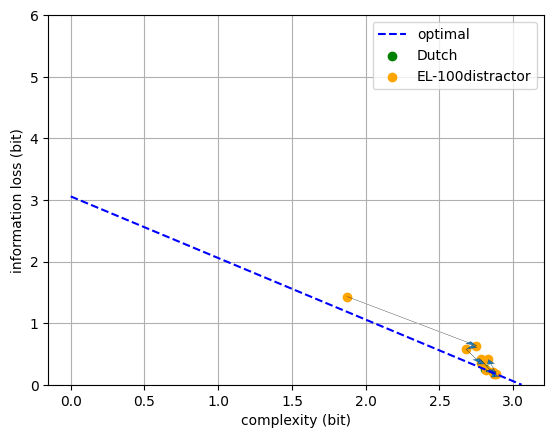

In [11]:
from matplotlib import pyplot as plt
# information loss = - complexity + entropy(u)

entropy_u = sum(-p_u[u] * log2(p_u[u] + 1e-10) for u in p_u.keys())
plt.plot([0, entropy_u], [entropy_u, 0], '--b')
plt.scatter([dutch['complexity']], [dutch['info loss']], color='green')

for eme_lang, color in zip(eme_langs.values(), ['orange', 'red', 'black', 'purple']):
    plt.scatter(
        [x['complexity'] for x in eme_lang], 
        [x['info loss'] for x in eme_lang], 
        color=color
    )

for eme_lang in eme_langs.values():
    for i in range(len(eme_lang)):
        l1, l2 = eme_lang[i-1], eme_lang[i]
        if i > 0: 
            plt.arrow(
                l1['complexity'], l1['info loss'], 
                l2['complexity'] - l1['complexity'],
                l2['info loss'] - l1['info loss'],
                shape='full', lw=0.1, length_includes_head=True, head_width=.05
            )

plt.xlabel('complexity (bit)')
plt.ylabel('information loss (bit)')
plt.legend(['optimal', 'Dutch'] + [f'EL-{n}distractor' for n in eme_langs.keys()])
plt.ylim(0, 6)
plt.grid()
plt.show()